In [17]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# Data parameters
from tqdm import tqdm
from configs.RecursiveVPSDE.Markovian_fBiPotDDims.recursive_Markovian_PostMeanScore_fBiPot8Dims_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
from utils.drift_evaluation_functions import multivar_score_based_MLP_drift_OOS
import os
import torch
config = get_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
time_ax = np.linspace(0, 1/256*(256),257)

In [19]:
type = "score"

In [20]:
save_path = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/QuadSinHF_NewLongerDriftEvalExp_MSEs_10240NPaths"
normalnoise_score_drifts = np.load(save_path + f"_score_drifts.npy", allow_pickle=True)[:, :257, 0]
normalnoise_hermite_drifts = np.load(save_path + f"_hermite_drifts.npy", allow_pickle=True)[:, :257, 0]
normalnoise_true_drifts = np.load(save_path + "_true_drifts.npy", allow_pickle=True)[:, :257, 0]
normalnoise_score_paths = np.load(save_path + f"_score_paths.npy", allow_pickle=True)[:, :257, 0]
normalnoise_hermite_paths = np.load(save_path + f"_hermite_paths.npy", allow_pickle=True)[:, :257, 0]
normalnoise_true_paths = np.load(save_path + "_true_paths.npy", allow_pickle=True)[:, :257, 0]
normalnoise_score_diffs = normalnoise_true_paths-normalnoise_score_paths
idxs = np.argsort(np.abs(normalnoise_score_diffs)[:, -1], axis=0).flatten()

normalnoise_true_drifts = normalnoise_true_drifts[idxs, :][::-1, :]/256
normalnoise_score_drifts = normalnoise_score_drifts[idxs, :][::-1,:]/256
normalnoise_hermite_drifts = normalnoise_hermite_drifts[idxs, :][::-1,:]/256

normalnoise_true_paths = normalnoise_true_paths[idxs, :][::-1, :]
normalnoise_score_paths = normalnoise_score_paths[idxs, :][::-1,:]
normalnoise_hermite_paths = normalnoise_hermite_paths[idxs, :][::-1,:]

In [21]:
assert (config.hurst == 0.5)
assert (config.early_stop_idx == 0)
assert (config.tdata_mult == 110)
#assert (config.sin_space_scale == 25.)
assert (config.feat_thresh == 1./100.)
print(config.scoreNet_trained_path, config.dataSize)
rng = np.random.default_rng()
scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(
    *config.model_parameters)
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
device_id = "cpu"
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and "EE" in file:
        print(file)
        entered = True
        scoreModel.load_state_dict(torch.load(os.path.join(model_dir, file)))
assert entered

/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_ST_0010FTh_PM_MLP_2LFac_NSTgtNFMReg_fBiPot_8DDims_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-20b_00c_MLP_H4_CUp20_tl110 40000
trained_rec_ST_0010FTh_PM_MLP_2LFac_NSTgtNFMReg_fBiPot_8DDims_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-20b_00c_MLP_H4_CUp20_tl110_EENEp12876


In [22]:
import torch.nn.functional as F
def experiment_MLP_1D_drifts(config, es,Xs, numstates,good, onlyGauss=False):
    if config.has_cuda:
        device = 0#int(os.environ["LOCAL_RANK"])
    else:
        device = torch.device("cpu")
    Xs = torch.Tensor(Xs).to(device)
    good = good.to(device)
    diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
    ts_step = config.deltaT
    Xshape = Xs.shape[0]#config.ts_length
    num_taus = numstates

    num_diff_times = config.max_diff_steps
    Ndiff_discretisation = config.max_diff_steps
    diffusion_times = torch.linspace(start=config.sample_eps, end=config.end_diff_time,
                                     steps=Ndiff_discretisation).to(device)

    features_tensor = torch.stack([Xs for _ in range(1)], dim=0).reshape(Xshape * 1, 1, -1).to(device)
    vec_Z_taus = diffusion.prior_sampling(shape=(Xshape * num_taus, 1, config.ts_dims)).to(device) #torch.zeros(size=(Xshape * num_taus, 1, config.ts_dims)).to(device)#
    z_alt = vec_Z_taus.view(Xshape, num_taus, 1, config.ts_dims).permute(1, 0, 2, 3)
    vec_Z_taus = z_alt.reshape(num_taus * Xshape, 1, config.ts_dims)
    # run near the top of the function after you have features_tensor and vec_Z_taus (after you applied Fix A)

    # ts = []
    es = num_diff_times - es
    final_vec_mu_hats = np.zeros(
        (Xshape, es, num_taus, config.ts_dims))  # Xvalues, DiffTimes, Ztaus, Ts_Dims

    ts = []
    # mu_hats_mean = np.zeros((tot_num_feats, num_taus))
    # mu_hats_std = np.zeros((tot_num_feats, num_taus))
    good.eval()
    insert_idx=-1
    with torch.inference_mode():

        for difftime_idx in (np.arange(num_diff_times - 1, num_diff_times - es - 1, -1)): #difftime_idx >= num_diff_times - es:
            d = diffusion_times[Ndiff_discretisation - (num_diff_times - 1 - difftime_idx) - 1].to(device)
            diff_times = torch.stack([d for _ in range(Xshape)]).reshape(Xshape * 1).to(device)
            eff_times = diffusion.get_eff_times(diff_times=diff_times).unsqueeze(-1).unsqueeze(-1).to(device)
            vec_diff_times = torch.stack([diff_times for _ in range(num_taus)], dim=0).reshape(num_taus * Xshape)
            vec_eff_times = torch.stack([eff_times for _ in range(num_taus)], dim=0).reshape(num_taus * Xshape, 1, 1)
            vec_conditioner = torch.stack([features_tensor for _ in range(num_taus)], dim=0).reshape(
                num_taus * Xshape,
                1, -1)
            with torch.no_grad():
                if onlyGauss:
                    scoreEval_vec_Z_taus = torch.randn_like(vec_Z_taus).to(device)
                else:
                    scoreEval_vec_Z_taus = vec_Z_taus
                good.eval()
                vec_predicted_score = good.forward(inputs=scoreEval_vec_Z_taus, times=vec_diff_times, conditioner=vec_conditioner,
                                                 eff_times=vec_eff_times)

            beta_taus = torch.exp(-0.5 * eff_times[0, 0, 0]).to(device)
            sigma_taus = torch.pow(1. - torch.pow(beta_taus, 2), 0.5).to(device)
            sigma2_taus=torch.pow(1. - torch.pow(beta_taus, 2), 1.).to(device)
            predicted_score = -scoreEval_vec_Z_taus/sigma2_taus + (beta_taus/sigma2_taus)*vec_predicted_score
            vec_scores, vec_drift, vec_diffParam = diffusion.get_conditional_reverse_diffusion(x=vec_Z_taus,
                                                                                               predicted_score=predicted_score,
                                                                                               diff_index=torch.Tensor(
                                                                                                   [int((
                                                                                                           num_diff_times - 1 - difftime_idx))]).to(
                                                                                                   device),
                                                                                               max_diff_steps=Ndiff_discretisation)

            if "PM" in config.scoreNet_trained_path:
                final_mu_hats = (-beta_taus*scoreEval_vec_Z_taus / (sigma2_taus)) + ((
                                                                                (torch.pow(sigma_taus, 2) + (
                                                                                        torch.pow(beta_taus * config.diffusion,
                                                                                                2) * ts_step)) / (
                                                                                        ts_step * sigma2_taus)) * vec_predicted_score)
            else:
                final_mu_hats = (scoreEval_vec_Z_taus / (ts_step * beta_taus)) + ((
                                                                                (sigma2_taus + (
                                                                                        torch.pow(beta_taus * config.diffusion,
                                                                                                2) * ts_step)) / (
                                                                                        ts_step * beta_taus)) * vec_scores)

            assert (final_mu_hats.shape == (num_taus * Xshape, 1, config.ts_dims))
            means = final_mu_hats.reshape((num_taus, Xshape, config.ts_dims))

            # print(vec_Z_taus.shape, vec_scores.shape)
            final_vec_mu_hats[:, insert_idx,:, :] = means.permute((1, 0, 2)).cpu().numpy()
            vec_z = torch.randn_like(vec_drift).to(device)
            vec_Z_taus = vec_drift + vec_diffParam * vec_z
            insert_idx -=1
    assert (final_vec_mu_hats.shape == (Xshape, es, num_taus, config.ts_dims))
    return final_vec_mu_hats, vec_predicted_score

In [23]:
numpaths = 1
Xs = torch.ones(size=(numpaths,config.ndims))

In [ ]:
es=9999
numreps = 1000
means = {k:np.inf for k in 10**(np.arange(2, 5))}
stds = {k:np.inf for k in 10**(np.arange(2, 5))}
for numtaus in 10**(np.arange(2, 5)):
    oneway = []
    for k in tqdm(range(numreps)):
        DNonGauss, sortScore = experiment_MLP_1D_drifts(good=scoreModel,es=es, Xs=Xs, numstates=numtaus, config=config, onlyGauss=False)
        DNonGauss = np.mean(DNonGauss[:, 0, :, :], axis=1)
        oneway.append(DNonGauss.reshape((1, DNonGauss.shape[0], DNonGauss.shape[1])))
    secondway = []
    for k in tqdm(range(numreps)):
        score_mean = multivar_score_based_MLP_drift_OOS(score_model=scoreModel,
                                                                     num_diff_times=1,numstates=numtaus,
                                                                     diffusion=diffusion,
                                                                     num_paths=numpaths,
                                                                     ts_step=config.deltaT, config=config,
                                                                     device=device_id,
                                                                     prev=Xs)[:, 0, :]
        secondway.append(score_mean.reshape((1, score_mean.shape[0], score_mean.shape[1])))
    diffs = np.concatenate(oneway, axis=0) - np.concatenate(secondway, axis=0)
    means[numtaus] = np.mean(diffs[:, 0, :], axis=0)
    stds[numtaus] = np.std(diffs[:, 0, :], axis=0)

 34%|███▍      | 343/1000 [01:23<02:48,  3.91it/s]

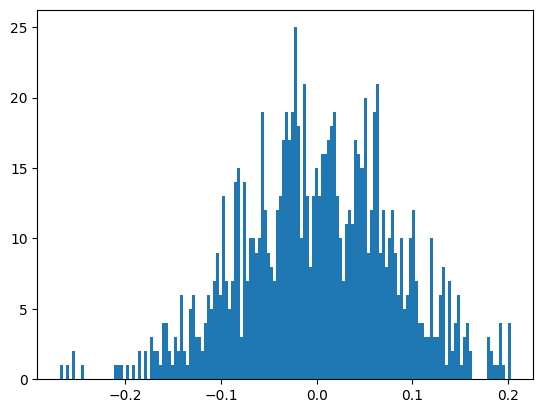

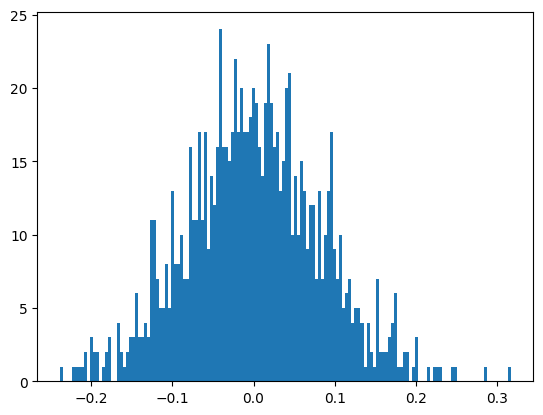

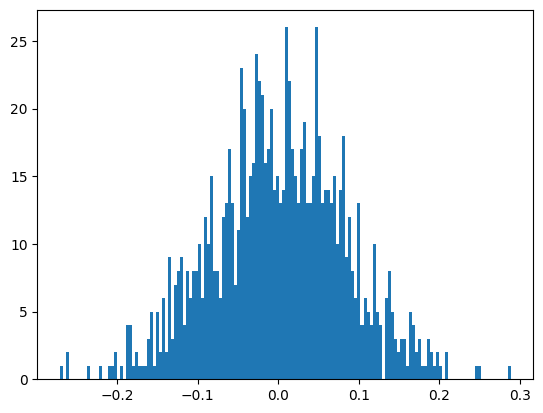

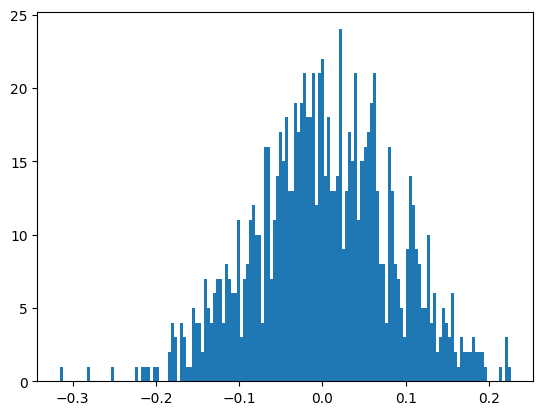

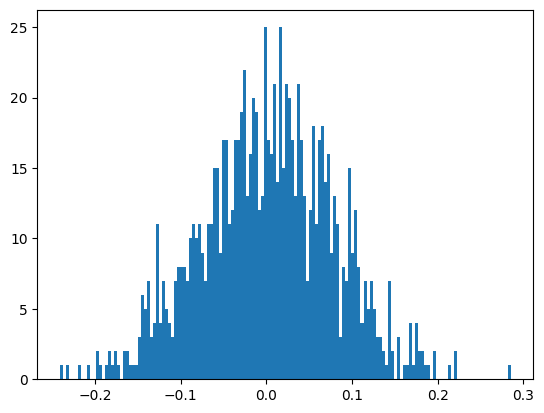

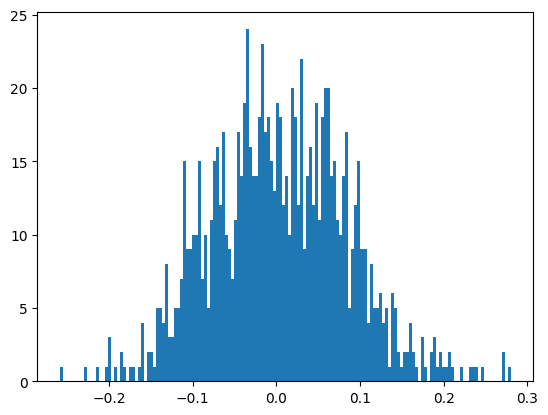

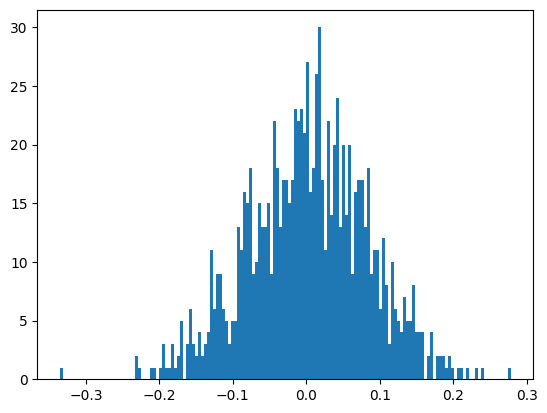

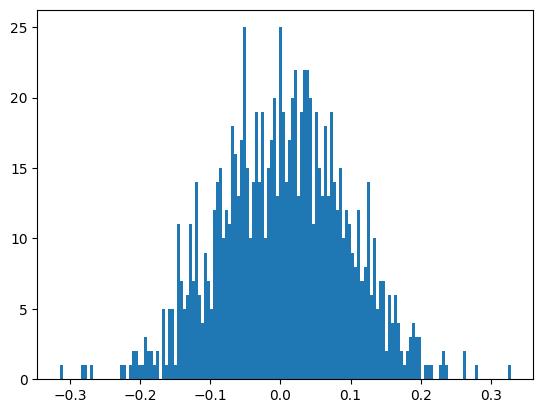

In [29]:
for d in range(8):
    plt.hist(diffs[:, 0, d], bins=150)
    plt.show()
    plt.close()